## Visualization Covid 19 data

### Data range analysis

In [26]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser

RAW_DATA_PATH = r"../data/raw"
PROCESSED_DATA_PATH = r"../data/processed"

In [27]:
covid_data = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "covid_data_cleaned.csv"))

In [28]:
print(covid_data.head())

   SNo ObservationDate Province/State  Country/Region          Last Update  \
0    1      2020-01-22          Anhui  Mainland China  2020-01-22 17:00:00   
1    2      2020-01-22        Beijing  Mainland China  2020-01-22 17:00:00   
2    3      2020-01-22      Chongqing  Mainland China  2020-01-22 17:00:00   
3    4      2020-01-22         Fujian  Mainland China  2020-01-22 17:00:00   
4    5      2020-01-22          Gansu  Mainland China  2020-01-22 17:00:00   

   Confirmed  Deaths  Recovered  
0          1       0          0  
1         14       0          0  
2          6       0          0  
3          1       0          0  
4          0       0          0  


In [29]:
# Convert ObservationDate to datetime
covid_data['ObservationDate'] = pd.to_datetime(covid_data['ObservationDate'], errors='coerce')

# Calculate the date range
start_date = covid_data['ObservationDate'].min()
end_date = covid_data['ObservationDate'].max()

print(f"Date Range: {start_date.date()} to {end_date.date()}")


Date Range: 2020-01-02 to 2021-12-05


In [30]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              306429 non-null  int64         
 1   ObservationDate  306429 non-null  datetime64[ns]
 2   Province/State   306429 non-null  object        
 3   Country/Region   306429 non-null  object        
 4   Last Update      306429 non-null  object        
 5   Confirmed        306429 non-null  int64         
 6   Deaths           306429 non-null  int64         
 7   Recovered        306429 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 18.7+ MB


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_trend_analysis(df, country=None):
    sns.set(style="whitegrid")

    # Đảm bảo cột ObservationDate là datetime
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    # Lọc theo quốc gia nếu được cung cấp
    if country:
        df = df[df['Country/Region'] == country]

    # Gom nhóm theo ngày
    daily = df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

    # Tính trung bình trượt 7 ngày
    daily['Confirmed_MA'] = daily['Confirmed'].rolling(window=7).mean()
    daily['Deaths_MA'] = daily['Deaths'].rolling(window=7).mean()
    daily['Recovered_MA'] = daily['Recovered'].rolling(window=7).mean()

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))

    # Confirmed trend
    plt.subplot(3, 1, 1)
    sns.lineplot(data=daily, x='ObservationDate', y='Confirmed_MA', color='blue')
    plt.title(f'Confirmed Cases Trend{" in " + country if country else ""}')
    plt.ylabel('Confirmed (7-day MA)')

    # Deaths trend
    plt.subplot(3, 1, 2)
    sns.lineplot(data=daily, x='ObservationDate', y='Deaths_MA', color='red')
    plt.title(f'Deaths Trend{" in " + country if country else ""}')
    plt.ylabel('Deaths (7-day MA)')

    # Recovered trend
    plt.subplot(3, 1, 3)
    sns.lineplot(data=daily, x='ObservationDate', y='Recovered_MA', color='green')
    plt.title(f'Recoveries Trend{" in " + country if country else ""}')
    plt.ylabel('Recovered (7-day MA)')
    plt.xlabel('Date')

    plt.tight_layout()
    plt.show()


In [32]:
def plot_comparison_trend(df, countries):
    sns.set(style="whitegrid")
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    plt.figure(figsize=(14, 6))

    for country in countries:
        country_df = df[df['Country/Region'] == country]
        daily = country_df.groupby('ObservationDate')['Confirmed'].sum().rolling(window=7).mean().reset_index()
        daily_7ma = daily.rolling(window=7).mean()
        sns.lineplot(x=daily_7ma.index, y=daily_7ma.values, label=country)
        sns.lineplot(data=daily, x='ObservationDate', y='Confirmed', label=country)

    plt.title("7-Day Moving Average of Confirmed Cases")
    plt.xlabel("Date")
    plt.ylabel("Confirmed Cases")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Gọi trend toàn cầu (gộp tất cả quốc gia)

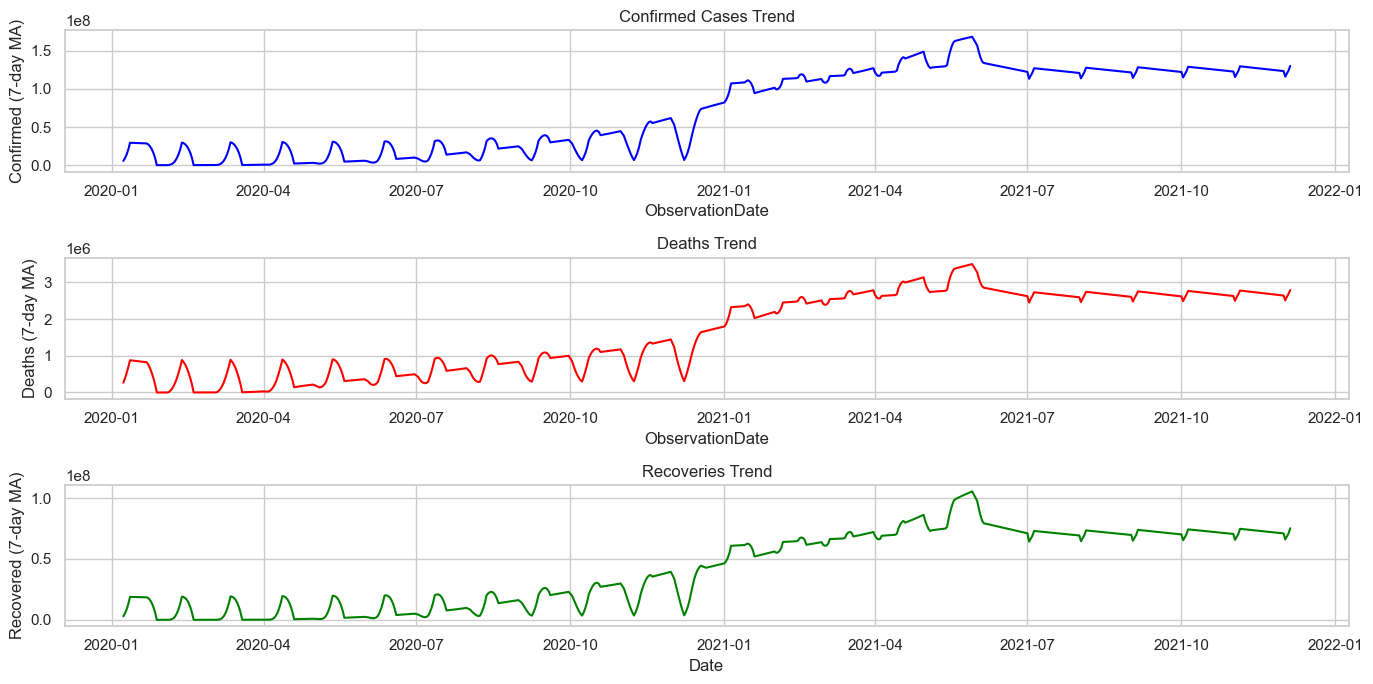

In [33]:
plot_trend_analysis(covid_data)


### Gọi trend cho một quốc gia cụ thể, ví dụ "Vietnam":

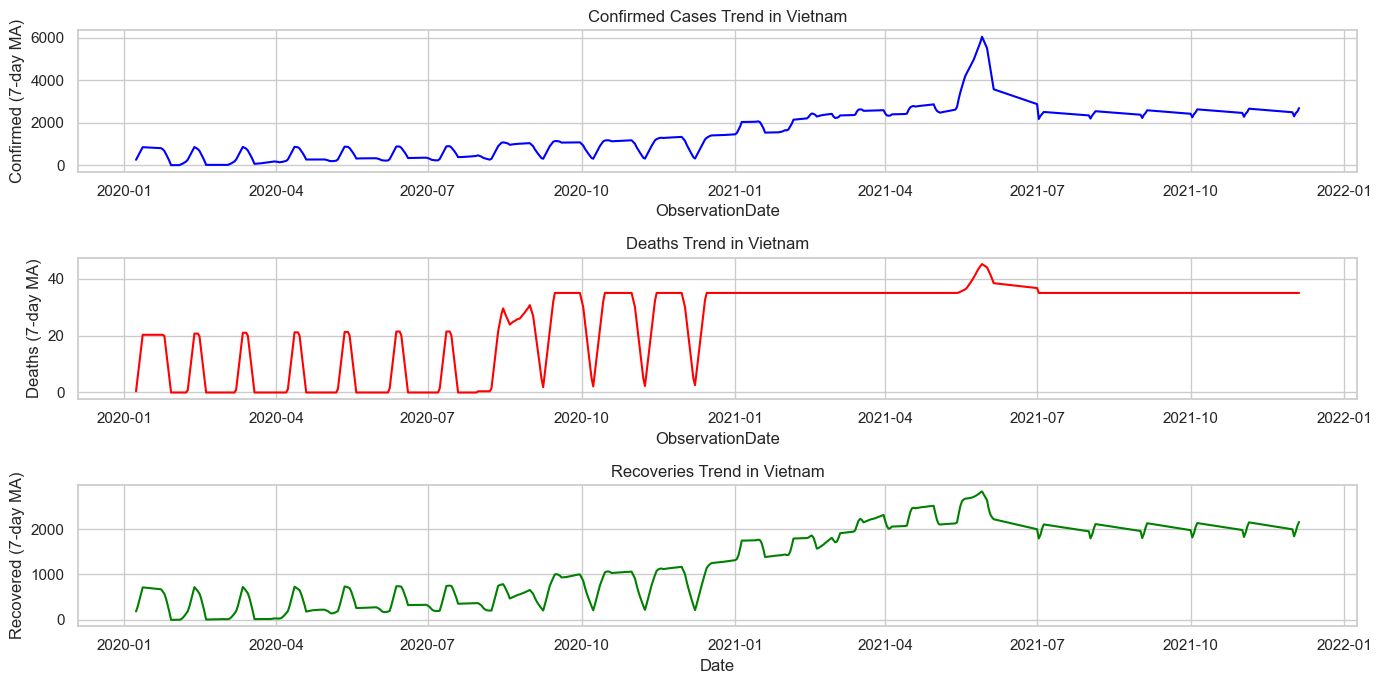

In [34]:
plot_trend_analysis(covid_data, country="Vietnam")


### Tính tăng trưởng hàng ngày và hàng tuần cho toàn thế giới (có thể lọc theo quốc gia sau nếu muốn)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có: covid_data (dữ liệu gốc)
df_full_grouped = covid_data.copy()

# Đảm bảo cột ngày đúng kiểu
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm theo ngày (toàn cầu hoặc quốc gia tùy chọn)
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths']].sum().reset_index()

# Tính tăng trưởng hằng ngày (daily growth rate %)
df_full_grouped['Daily Growth Rate (Cases)'] = df_full_grouped['Confirmed'].pct_change().fillna(0) * 100
df_full_grouped['Daily Growth Rate (Deaths)'] = df_full_grouped['Deaths'].pct_change().fillna(0) * 100

# Tăng trưởng hằng tuần (so với 7 ngày trước)
df_full_grouped['Weekly Growth Rate (Cases)'] = df_full_grouped['Confirmed'].pct_change(periods=7).fillna(0) * 100
df_full_grouped['Weekly Growth Rate (Deaths)'] = df_full_grouped['Deaths'].pct_change(periods=7).fillna(0) * 100

# Xem dữ liệu
df_full_grouped.head(50)[['ObservationDate', 'Confirmed', 'Deaths',
                          'Daily Growth Rate (Cases)', 'Daily Growth Rate (Deaths)',
                          'Weekly Growth Rate (Cases)', 'Weekly Growth Rate (Deaths)']]


,ObservationDate,Confirmed,Deaths,Daily Growth Rate (Cases),Daily Growth Rate (Deaths),Weekly Growth Rate (Cases),Weekly Growth Rate (Deaths)
0,2020-01-02,12038,259,0.000000,0.000000,0.000000,0.000000
1,2020-01-03,88368,2996,634.075428,1056.756757,0.000000,0.000000
2,2020-01-04,932440,47363,955.178345,1480.874499,0.000000,0.000000
3,2020-01-05,3346774,239834,258.926472,406.374174,0.000000,0.000000
4,2020-01-06,6268969,376350,87.313783,56.921037,0.000000,0.000000
5,2020-01-07,10706794,516178,70.790348,37.153713,0.000000,0.000000
6,2020-01-08,17866501,685278,66.870690,32.760017,0.000000,0.000000
7,2020-01-09,25792955,857422,44.364893,25.120316,214162.792823,330950.965251
8,2020-01-10,34344786,1023487,33.155685,19.367943,38765.636882,34061.782377
9,2020-01-11,46639333,1201797,35.797419,17.421814,4901.858886,2437.417393


### Top 10 quốc gia có nhiều ca nhiễm, tử vong, hồi phục

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20472\3072665124.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20472\3072665124.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20472\3072665124.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




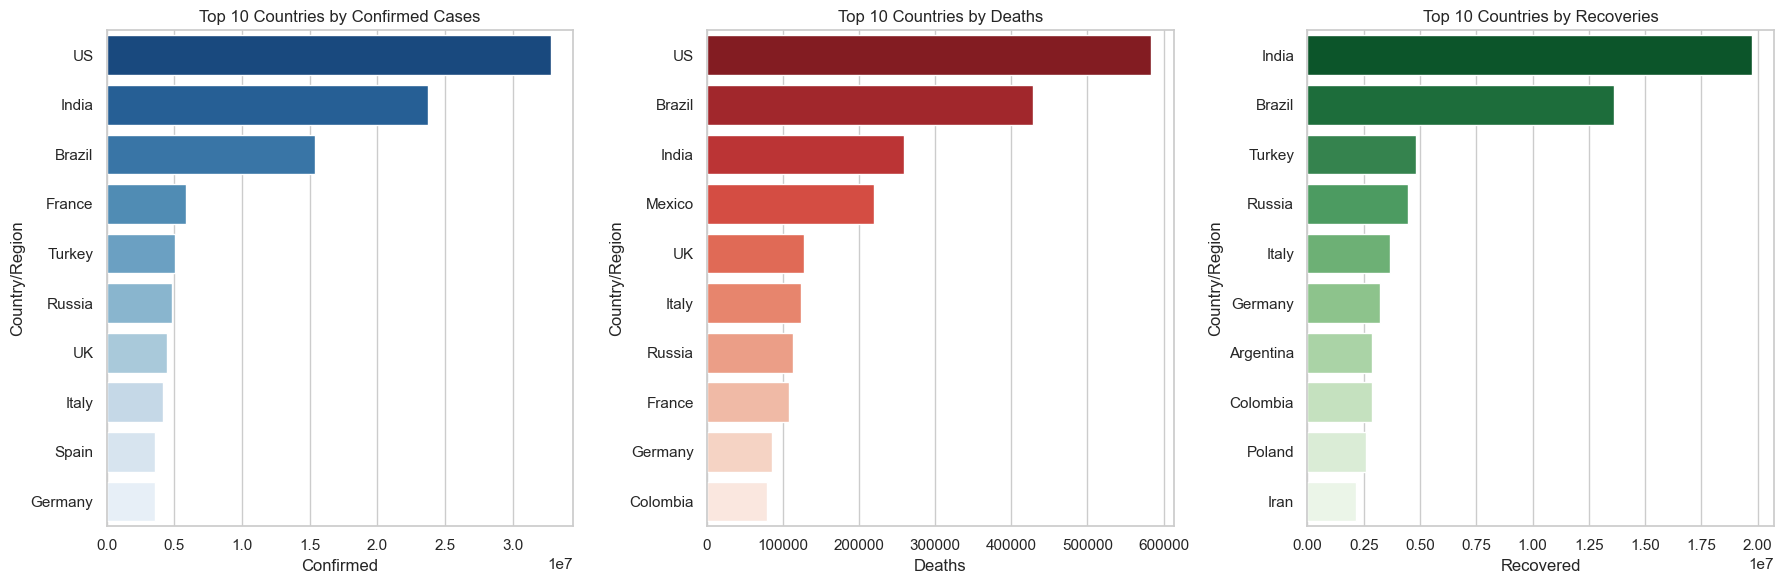

In [36]:
# Lấy dữ liệu mới nhất theo từng quốc gia
df_country_wise_latest = covid_data.copy()
latest_date = df_country_wise_latest['ObservationDate'].max()

# Lọc data mới nhất
df_country_wise_latest = df_country_wise_latest[df_country_wise_latest['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Top 10 quốc gia theo từng chỉ số
top_countries_cases = df_country_wise_latest.nlargest(10, 'Confirmed')[['Country/Region', 'Confirmed']]
top_countries_deaths = df_country_wise_latest.nlargest(10, 'Deaths')[['Country/Region', 'Deaths']]
top_countries_recovered = df_country_wise_latest.nlargest(10, 'Recovered')[['Country/Region', 'Recovered']]

# Vẽ biểu đồ bar
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x='Confirmed', y='Country/Region', data=top_countries_cases, ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 10 Countries by Confirmed Cases')

sns.barplot(x='Deaths', y='Country/Region', data=top_countries_deaths, ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Countries by Deaths')

sns.barplot(x='Recovered', y='Country/Region', data=top_countries_recovered, ax=axes[2], palette='Greens_r')
axes[2].set_title('Top 10 Countries by Recoveries')

plt.tight_layout()
plt.show()


### Tính tỷ lệ tử vong và hồi phục

In [37]:
df_country_wise_latest["Mortality Rate (%)"] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest["Recovery Rate (%)"] = (df_country_wise_latest['Recovered'] / df_country_wise_latest['Confirmed']) * 100

# Hiển thị kết quả
df_country_wise_latest[['Country/Region', 'Confirmed', 'Deaths', 'Recovered',
                        'Mortality Rate (%)', 'Recovery Rate (%)']].head(10)


,Country/Region,Confirmed,Deaths,Recovered,Mortality Rate (%),Recovery Rate (%)
0,Afghanistan,62718,2713,54534,4.325712,86.951115
1,Albania,131845,2423,120072,1.837764,91.070575
2,Algeria,124682,3350,86857,2.686835,69.662822
3,Andorra,13470,127,13104,0.942836,97.282851
4,Angola,29405,645,25187,2.193505,85.655501
5,Antigua and Barbuda,1240,32,1179,2.580645,95.080645
6,Argentina,3215572,68807,2869341,2.139806,89.232678
7,Armenia,219950,4272,206078,1.942260,93.693112
8,Australia,29955,910,23474,3.037890,78.364213
9,Austria,633960,10428,609666,1.644899,96.167897


### Phân tích theo tháng và tuần từ covid_data

In [38]:
df_full_grouped = covid_data.copy()
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm toàn cầu theo ngày
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Thêm cột Month, Week
df_full_grouped['Month'] = df_full_grouped['ObservationDate'].dt.month
df_full_grouped['Week'] = df_full_grouped['ObservationDate'].dt.isocalendar().week

# Gom nhóm theo tháng
monthly_data = df_full_grouped.groupby('Month')[['Confirmed', 'Deaths', 'Recovered']].mean()

# Gom nhóm theo tuần
weekly_data = df_full_grouped.groupby('Week')[['Confirmed', 'Deaths', 'Recovered']].mean()


### Vẽ biểu đồ tháng và tuần

<Figure size 1400x600 with 0 Axes>

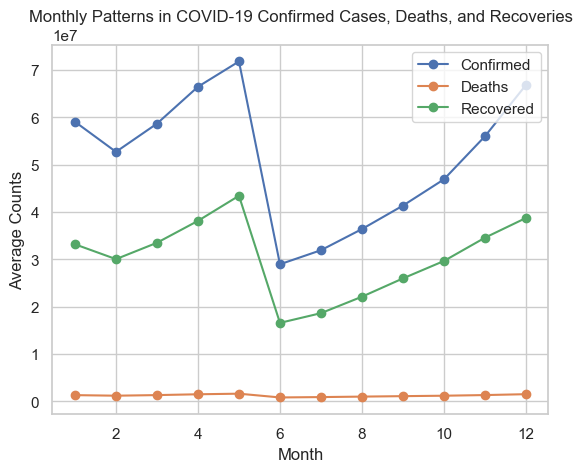

<Figure size 1400x600 with 0 Axes>

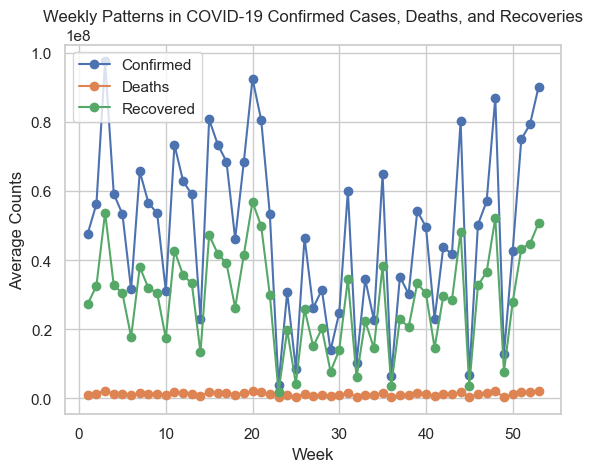

In [39]:
# Biểu đồ theo tháng
plt.figure(figsize=(14,6))
monthly_data.plot(kind='line', marker='o')
plt.title('Monthly Patterns in COVID-19 Confirmed Cases, Deaths, and Recoveries')
plt.xlabel('Month')
plt.ylabel('Average Counts')
plt.grid(True)
plt.show()

# Biểu đồ theo tuần
plt.figure(figsize=(14,6))
weekly_data.plot(kind='line', marker='o')
plt.title('Weekly Patterns in COVID-19 Confirmed Cases, Deaths, and Recoveries')
plt.xlabel('Week')
plt.ylabel('Average Counts')
plt.grid(True)
plt.show()


### Vẽ biểu đồ số ca nhiễm theo thời gian cho top 10 quốc gia

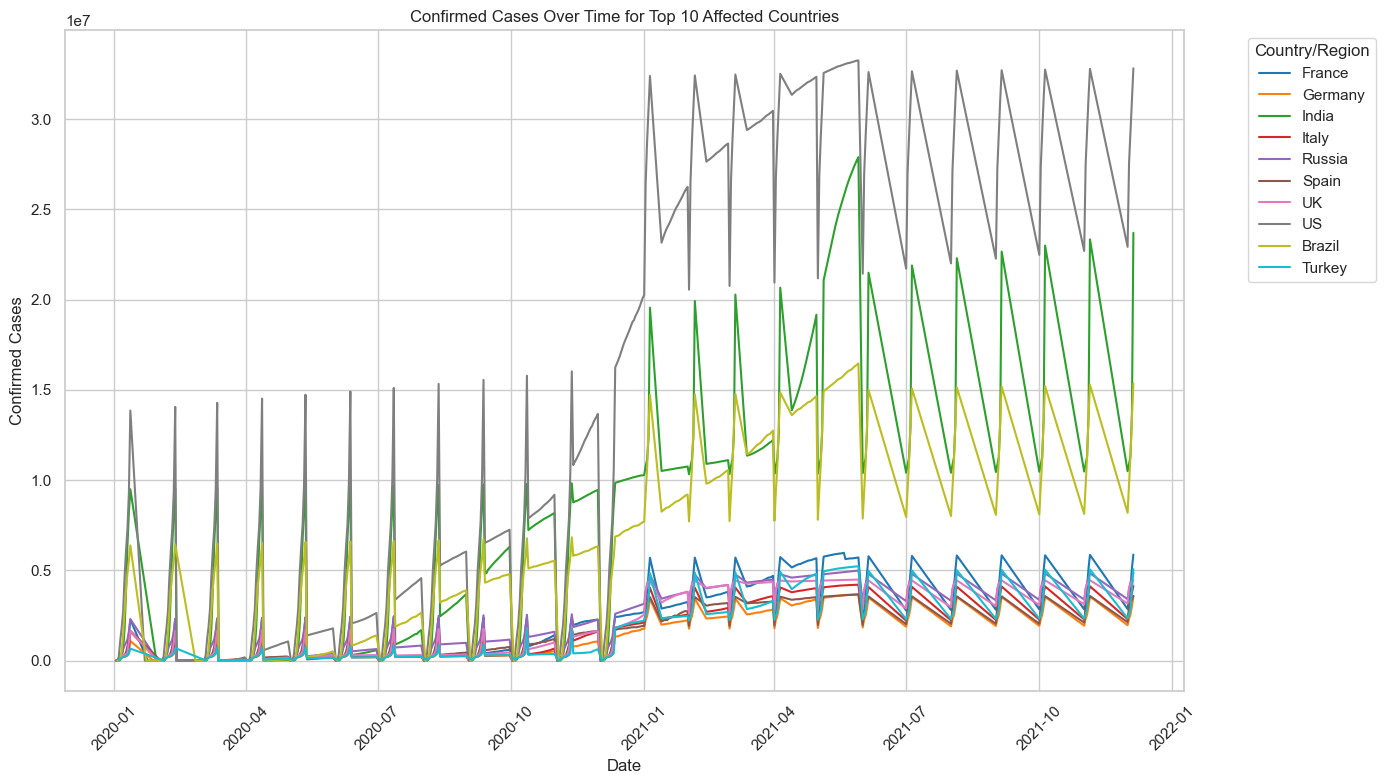

In [40]:
# Chuẩn bị dữ liệu country_wise mới nhất
latest_date = covid_data['ObservationDate'].max()
df_country_wise_latest = covid_data[covid_data['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Lấy top 10 quốc gia
top_10_countries_list = df_country_wise_latest.nlargest(10, 'Confirmed')['Country/Region'].tolist()

# Lọc dữ liệu theo các quốc gia này
df_top10 = covid_data[covid_data['Country/Region'].isin(top_10_countries_list)]

# Gom nhóm theo ngày và quốc gia
df_top10_grouped = df_top10.groupby(['ObservationDate', 'Country/Region'])[['Confirmed']].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14,8))
sns.lineplot(x='ObservationDate', y='Confirmed', hue='Country/Region', data=df_top10_grouped, palette='tab10')
plt.title('Confirmed Cases Over Time for Top 10 Affected Countries')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(title='Country/Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Tính và vẽ daily new cases/deaths/recoveries cho một quốc gia

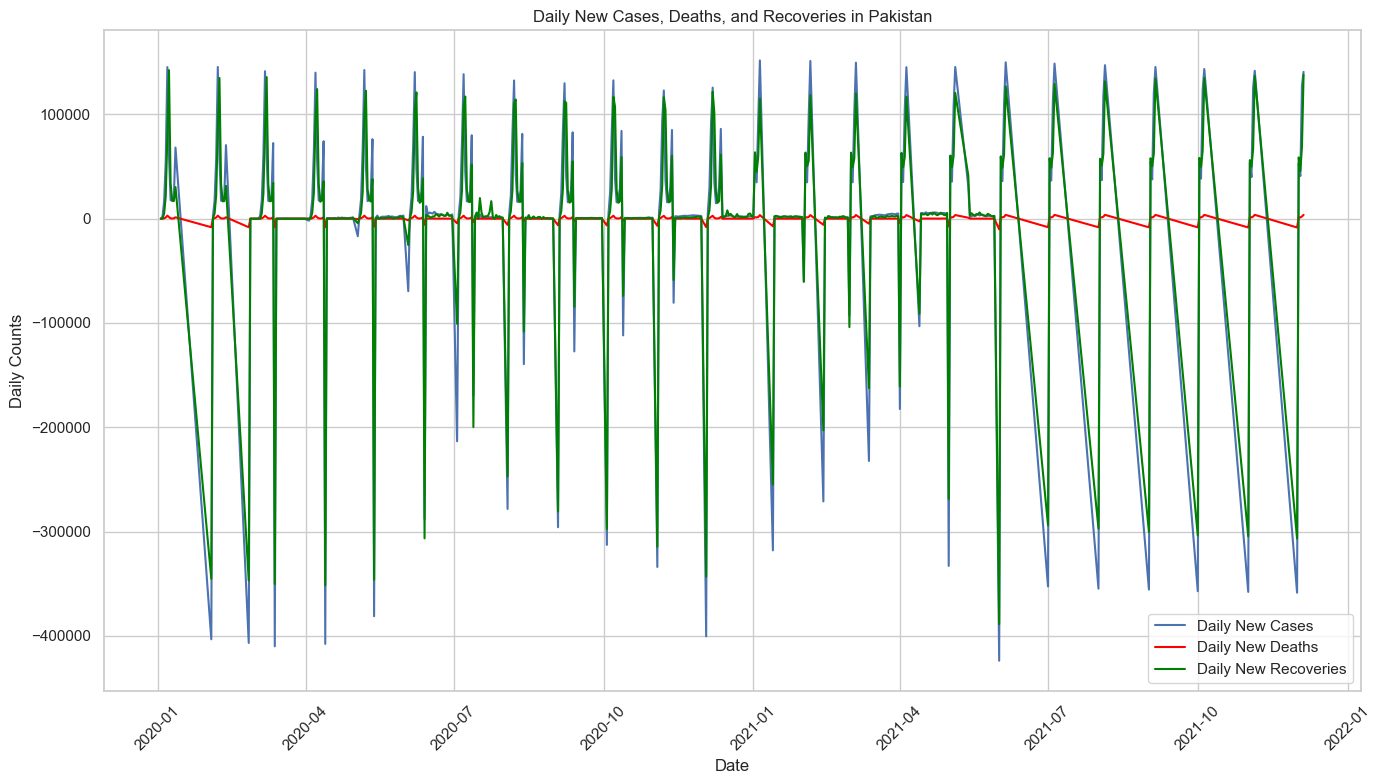

In [41]:
df_daily = covid_data.copy()
df_daily['ObservationDate'] = pd.to_datetime(df_daily['ObservationDate'])

# Gom nhóm để tránh trùng lặp theo ngày và quốc gia
df_daily = df_daily.groupby(['Country/Region', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Sắp xếp
df_daily = df_daily.sort_values(['Country/Region', 'ObservationDate'])

# Tính daily
df_daily['Daily New Cases'] = df_daily.groupby('Country/Region')['Confirmed'].diff().fillna(0)
df_daily['Daily New Deaths'] = df_daily.groupby('Country/Region')['Deaths'].diff().fillna(0)
df_daily['Daily New Recoveries'] = df_daily.groupby('Country/Region')['Recovered'].diff().fillna(0)

# Chọn quốc gia để vẽ
sample_country = df_daily[df_daily['Country/Region'] == 'Pakistan']

# Vẽ
plt.figure(figsize=(14, 8))
sns.lineplot(x='ObservationDate', y='Daily New Cases', data=sample_country, label='Daily New Cases')
sns.lineplot(x='ObservationDate', y='Daily New Deaths', data=sample_country, label='Daily New Deaths', color='red')
sns.lineplot(x='ObservationDate', y='Daily New Recoveries', data=sample_country, label='Daily New Recoveries', color='green')
plt.title('Daily New Cases, Deaths, and Recoveries in Pakistan')
plt.xlabel('Date')
plt.ylabel('Daily Counts')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Case Fatality Ratio (CFR)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20472\768388282.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




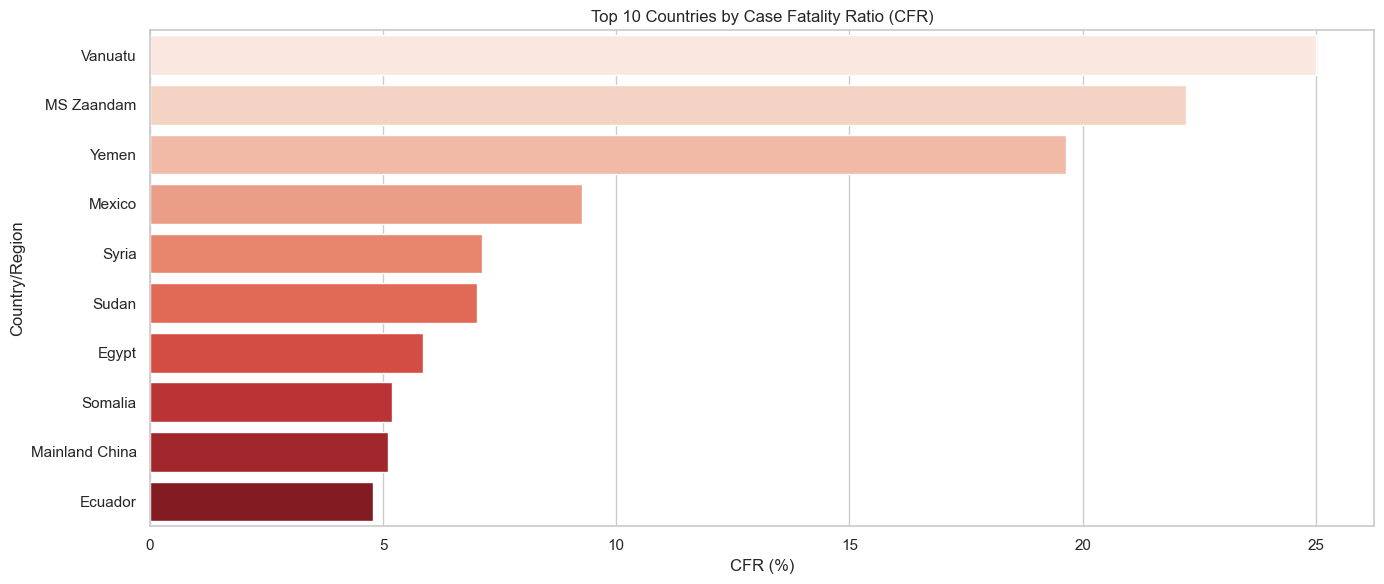

In [42]:
df_country_wise_latest['CFR (%)'] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest = df_country_wise_latest.replace([np.inf, -np.inf], np.nan).dropna(subset=['CFR (%)'])

top_10_cfr = df_country_wise_latest.nlargest(10, 'CFR (%)')

plt.figure(figsize=(14,6))
sns.barplot(x='CFR (%)', y='Country/Region', data=top_10_cfr, palette='Reds')
plt.title('Top 10 Countries by Case Fatality Ratio (CFR)')
plt.xlabel('CFR (%)')
plt.ylabel('Country/Region')
plt.tight_layout()
plt.show()


### Active vs Recovered Cases cho 1 quốc gia (ví dụ: India)

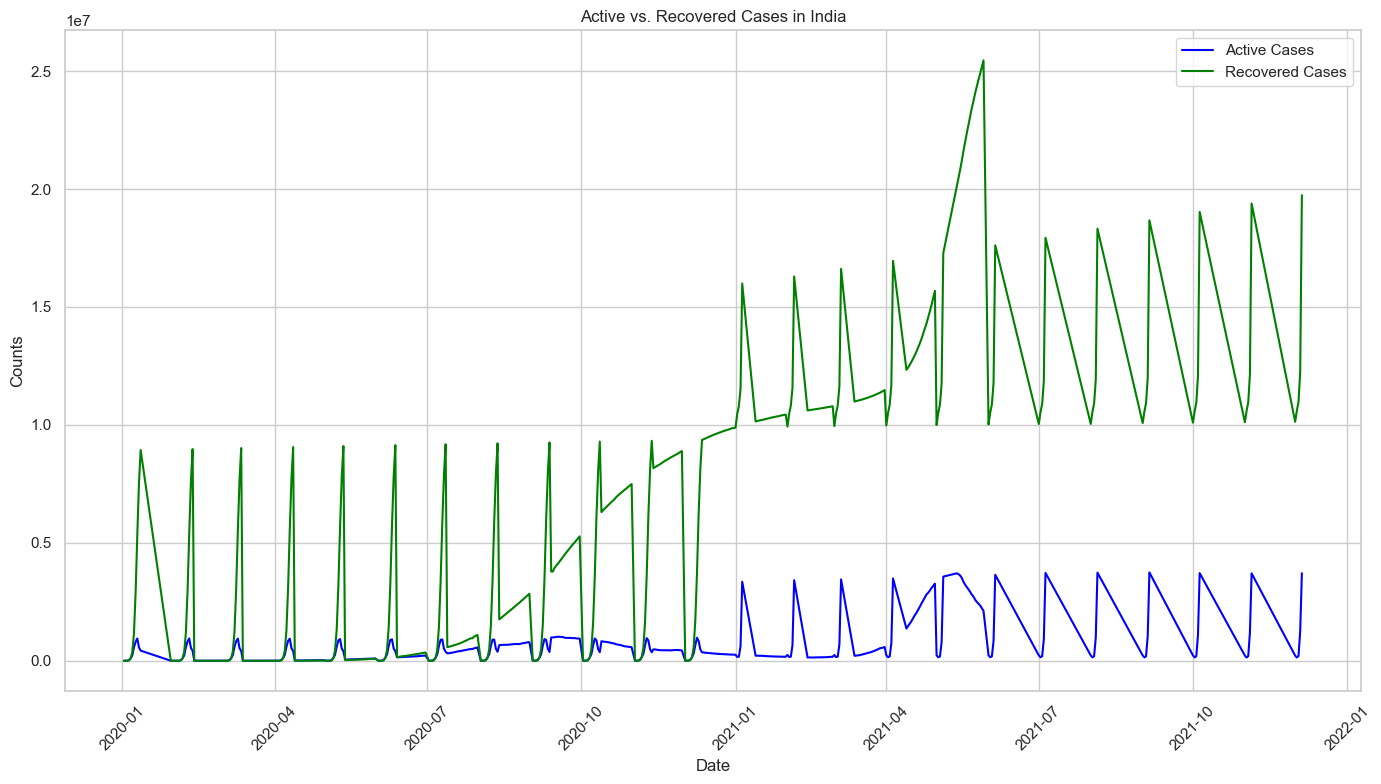

In [43]:
df_india = covid_data[covid_data['Country/Region'] == 'India'].copy()
df_india = df_india.groupby('ObservationDate')[['Confirmed', 'Recovered', 'Deaths']].sum().reset_index()

# Tính Active
df_india['Active'] = df_india['Confirmed'] - df_india['Recovered'] - df_india['Deaths']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
sns.lineplot(x='ObservationDate', y='Active', data=df_india, label='Active Cases', color='blue')
sns.lineplot(x='ObservationDate', y='Recovered', data=df_india, label='Recovered Cases', color='green')
plt.title('Active vs. Recovered Cases in India')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Xử lý dữ liệu theo châu lục

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
import numpy as np
from scipy.stats import pearsonr
# Bước 1: Lấy ngày mới nhất trong dữ liệu
latest_date = covid_data['ObservationDate'].max()

# Bước 2: Lọc dữ liệu ngày mới nhất
df_latest = covid_data[covid_data['ObservationDate'] == latest_date].copy()

# Bước 3: Gom nhóm theo quốc gia
df_latest_grouped = df_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Bước 4: Tính số ca đang nhiễm (Active = Confirmed - Deaths - Recovered)
df_latest_grouped['Active'] = df_latest_grouped['Confirmed'] - df_latest_grouped['Deaths'] - df_latest_grouped['Recovered']
import country_converter as coco
cc = coco.CountryConverter()

df_latest_grouped['Continent'] = cc.convert(names=df_latest_grouped['Country/Region'], to='continent')




Diamond Princess not found in regex
MS Zaandam not found in regex


Tổng số ca, tử vong, hồi phục theo châu lục (Continent)

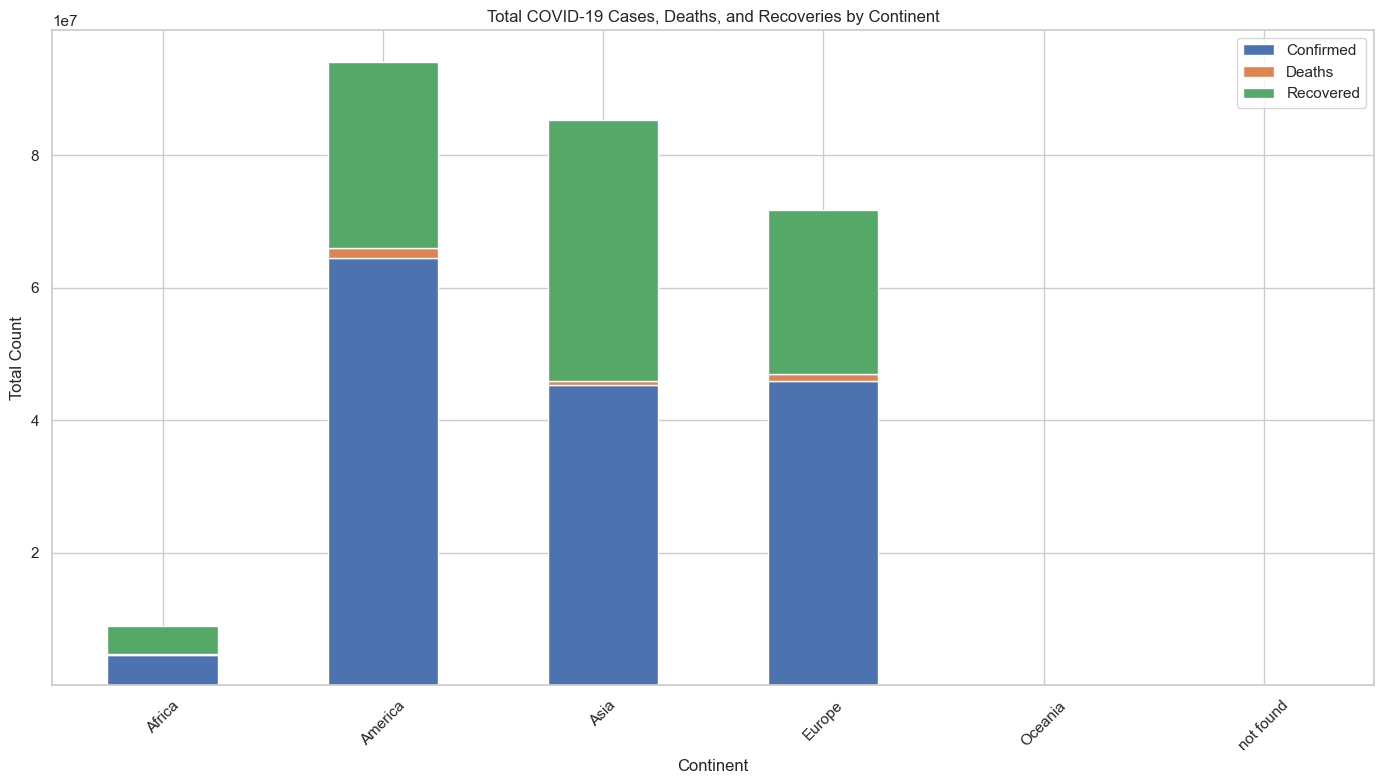

In [45]:
continent_data = df_latest_grouped.groupby('Continent')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Vẽ stacked bar chart
continent_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Total COVID-19 Cases, Deaths, and Recoveries by Continent')
plt.xlabel('Continent')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Tỷ lệ tử vong và hồi phục theo châu lục

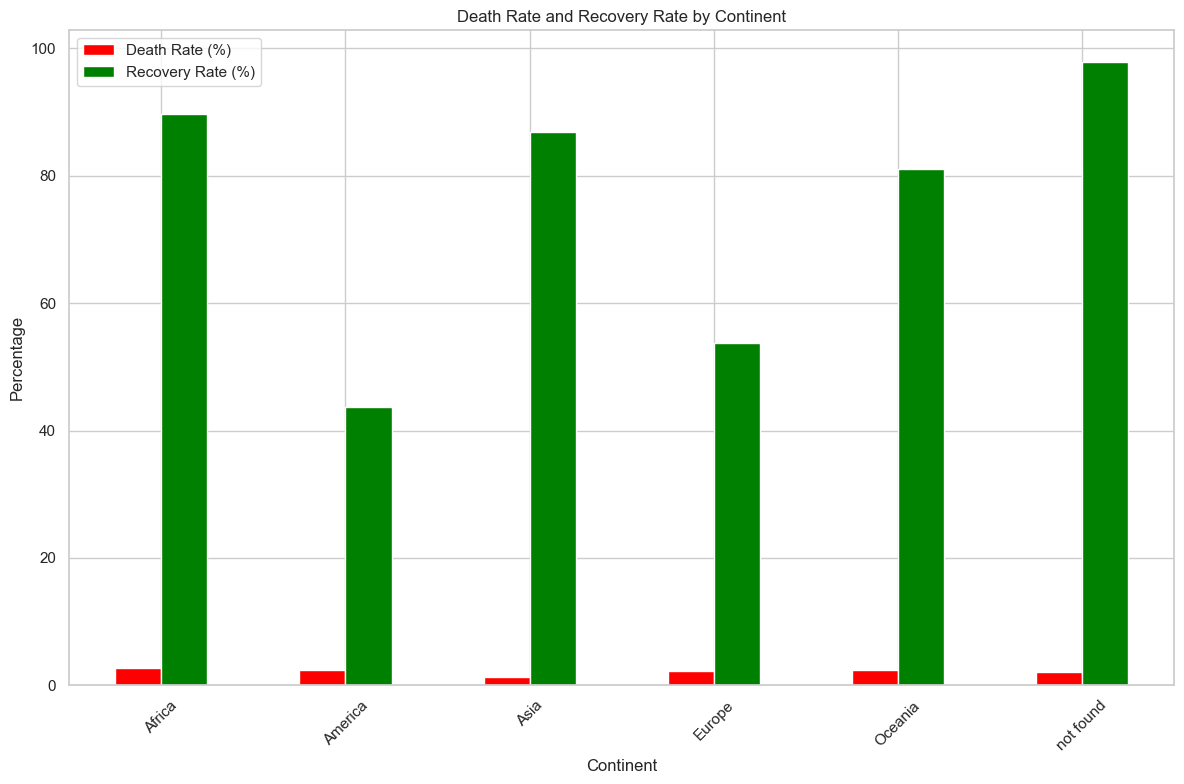

In [46]:
continent_data['Death Rate (%)'] = (continent_data['Deaths'] / continent_data['Confirmed']) * 100
continent_data['Recovery Rate (%)'] = (continent_data['Recovered'] / continent_data['Confirmed']) * 100

continent_data[['Death Rate (%)', 'Recovery Rate (%)']].plot(
    kind='bar', figsize=(12, 8), color=['red', 'green']
)
plt.title('Death Rate and Recovery Rate by Continent')
plt.xlabel('Continent')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Phân phối tổng ca bệnh theo châu lục

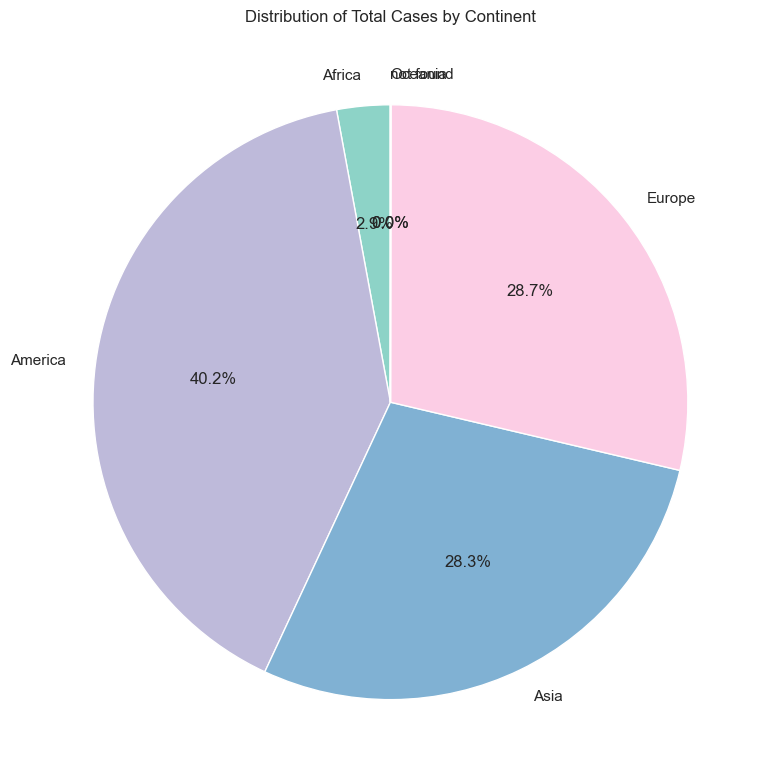

In [47]:
continent_cases = df_latest_grouped.groupby('Continent')['Confirmed'].sum()
plt.figure(figsize=(8, 8))
continent_cases.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Distribution of Total Cases by Continent')
plt.ylabel('')
plt.tight_layout()
plt.show()


Phân phối ca đang nhiễm (Active) theo châu lục

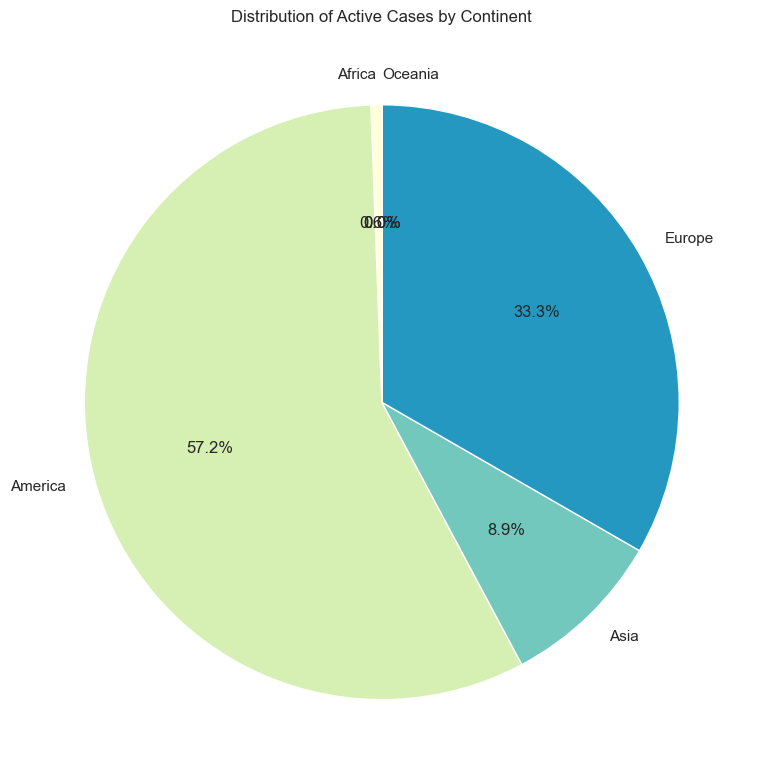

In [48]:
continent_active_cases = df_latest_grouped.groupby('Continent')['Active'].sum()
plt.figure(figsize=(8, 8))
continent_active_cases.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='YlGnBu')
plt.title('Distribution of Active Cases by Continent')
plt.ylabel('')
plt.tight_layout()
plt.show()


Tỷ lệ hồi phục, tử vong, đang nhiễm toàn cầu

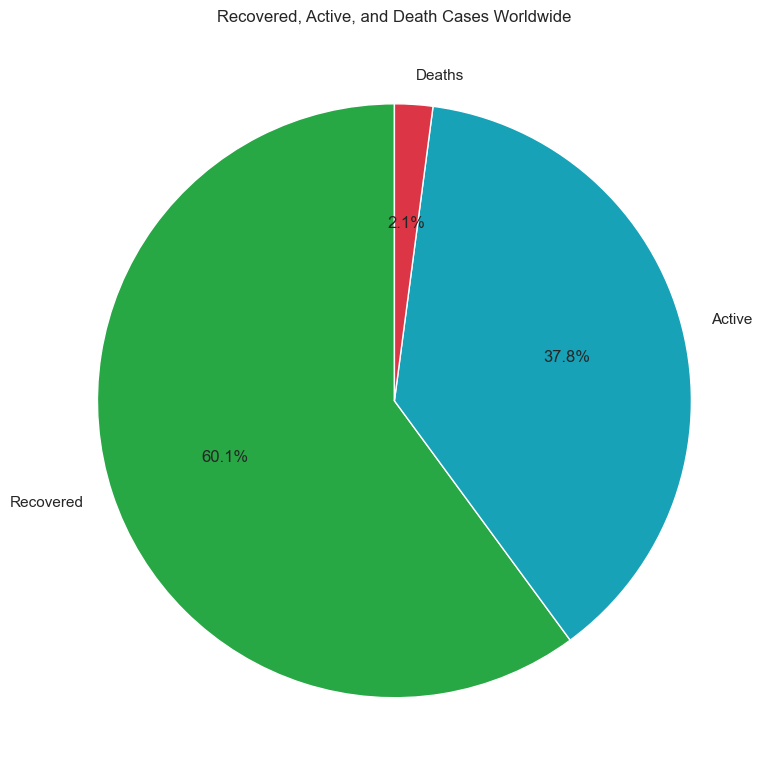

In [49]:
recovered_cases = df_latest_grouped['Recovered'].sum()
active_cases = df_latest_grouped['Active'].sum()
death_cases = df_latest_grouped['Deaths'].sum()

plt.figure(figsize=(8, 8))
plt.pie(
    [recovered_cases, active_cases, death_cases],
    labels=['Recovered', 'Active', 'Deaths'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#28a745', '#17a2b8', '#dc3545']
)
plt.title('Recovered, Active, and Death Cases Worldwide')
plt.tight_layout()
plt.show()


## Vẽ số ca bệnh của các nước lên bản đồ thế giới

In [50]:
import plotly.express as px


# Chuẩn bị dữ liệu: df_latest_grouped đã có cột 'Country/Region' và 'Confirmed'
# Nếu chưa có thì dùng đoạn xử lý ở trên để tạo

fig = px.scatter_geo(
    df_latest_grouped,
    locations="Country/Region",
    locationmode="country names",
    size="Confirmed",
    color_discrete_sequence=["red"],
    hover_name="Country/Region",
    hover_data={"Confirmed": True},
    projection="natural earth",
    title="Global COVID-19 Infections by Country (Bubble Map)",
    size_max=50  # bạn có thể chỉnh max size của chấm
)

fig.update_layout(
    geo=dict(showland=True, landcolor="lightgray"),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()
